In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import evaluate
import os
import torch
from datasets import load_dataset
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)

In [4]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Load the SQuAD dataset
squad_dataset = load_dataset("squad")

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [6]:
# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 uses EOS token as padding


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Define maximum sequence length
max_input_length = 512  # Reduce to fit GPU memory


In [8]:
# Preprocess function
def preprocess_function(examples):
    inputs = []
    for question, context, answers in zip(
        examples['question'], examples['context'], examples['answers']
    ):
        # Extract the first answer
        answer_texts = answers['text'] if 'text' in answers else [""]
        answer = answer_texts[0] if len(answer_texts) > 0 else ""
        
        # Prepare input text
        input_text = f"Question: {question} Context: {context} Answer: {answer}"
        inputs.append(input_text)

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding='max_length',
    )
    return model_inputs

In [9]:
# Downsample the dataset
sample_percent = 100

train_size = len(squad_dataset["train"]) * (sample_percent / 100)
val_size = len(squad_dataset["validation"]) * (sample_percent / 100)

# Shuffle and select a random subset of 1000 examples
squad_dataset["train"] = squad_dataset["train"].shuffle(seed=42).select(range(int(train_size)))
squad_dataset["validation"] = squad_dataset["validation"].shuffle(seed=42).select(range(int(val_size)))

In [10]:
# Tokenize the datasets
tokenized_datasets = squad_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=squad_dataset["train"].column_names,
)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [11]:
# Convert to torch Dataset
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask'])

In [12]:
# Load the DistilGPT-2 model
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model.resize_token_embeddings(len(tokenizer))
model.to(device)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [13]:
# Define data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

In [14]:
# Training arguments
training_args = TrainingArguments(
    run_name="Test_Run_GPT2",
    report_to="none", # Prevent using Weights and Bias so API key not needed
    output_dir="./distilgpt2-finetuned-squad",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Reduce batch size to fit GPU memory
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,  # Accumulate gradients
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    eval_steps=1,
    learning_rate=5e-5,
    weight_decay=0.01,
    fp16=True,  # Enable mixed precision if supported
    load_best_model_at_end=True,
    save_safetensors=False,  # Prevents error in missing key lm_weight.head https://discuss.huggingface.co/t/unable-to-load-checkpoint-after-finetuning/50693/2
)

In [15]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [16]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,3.071300,3.372038
2,2.938400,3.417477
3,2.792000,3.438056


TrainOutput(global_step=32850, training_loss=3.0024682254878354, metrics={'train_runtime': 13774.8705, 'train_samples_per_second': 19.078, 'train_steps_per_second': 2.385, 'total_flos': 3.433400108266291e+16, 'train_loss': 3.0024682254878354, 'epoch': 3.0})

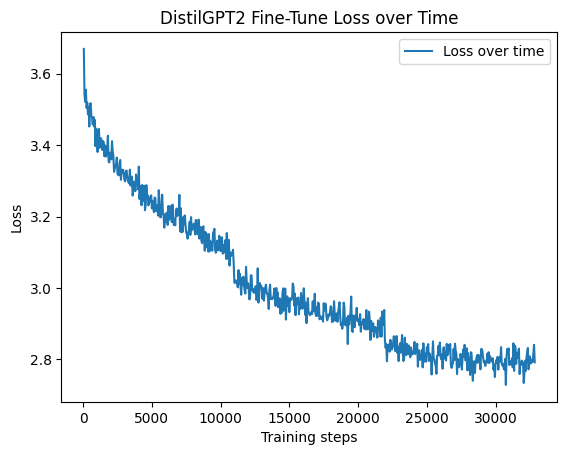

In [17]:
# Print loss over time

log_history = trainer.state.log_history

loss_values = []
steps = []

for log in log_history:
    if 'loss' in log:
        loss_values.append(log['loss'])
        steps.append(log['step'])
        
plt.plot(steps, loss_values, label="Loss over time")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("DistilGPT2 Fine-Tune Loss over Time")
plt.legend()
plt.show()

In [18]:
# Save the fine-tuned model
trainer.save_model("./distilgpt2-finetuned-squad")

In [19]:
# Load the fine-tuned model
model = GPT2LMHeadModel.from_pretrained("./distilgpt2-finetuned-squad").to(device)

# Prepare input
test_question = "What is the capital of France?"
test_context = "France is a country in Western Europe. It is known for its art, gastronomy, and culture. The capital city is Paris."
input_text = f"Question: {test_question} Context: {test_context} Answer:"

# Tokenize input
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

# Generate answer
output_ids = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    early_stopping=True
)

# Decode and print the answer
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Question: What is the capital of France? Context: France is a country in Western Europe. It is known for its art, gastronomy, and culture. The capital city is Paris. Answer: Paris. Answer: Paris. Answer: Paris
